In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

last_date_raw = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_str = str(last_date_raw).split('\'')[1]
last_date = dt.datetime.strptime(last_date_str,'%Y-%m-%d')
last_date

datetime.datetime(2017, 8, 23, 0, 0)

In [12]:
one_year_earlier = last_date.replace(year = last_date.year - 1)
one_year_earlier

datetime.datetime(2016, 8, 23, 0, 0)

In [13]:
# Perform a query to retrieve the data and precipitation scores
measurements = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date>one_year_earlier).all()
measurements

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
dates = []
prcp = []
for i in range(len(measurements)):
    dates.append(list(measurements[i])[0])
    prcp.append(list(measurements[i])[1])

prcp_df = pd.DataFrame({
    'prcp' : prcp
}, index=dates)

# Sort the dataframe by date
prcp_df.sort_index(inplace=True)

prcp_df.head()

,prcp
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


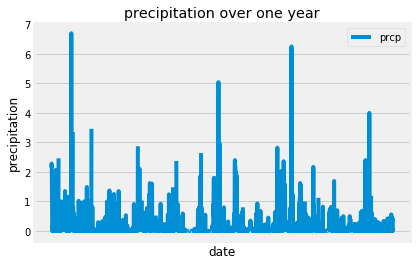

In [15]:
#plot
prcp_df.plot(title = 'precipitation over one year')
plt.xlabel('date')
plt.ylabel('precipitation')
plt.xticks([])
plt.savefig('output/prcp-over-one-year')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#### Station Analysis

In [17]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station, Station.name).all()
len(stations)
# 9 stations in the stations table

9

In [19]:
meas_stations = session.query(Measurement.station).group_by(Measurement.station).all()
len(meas_stations)
# 9 stations in the measurements table too

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
measurements_count = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
                    group_by(Measurement.station).\
                    order_by(desc('count')).all()
measurements_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = measurements_count[0][0]
most_active_station

'USC00519281'

In [22]:
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter_by(station=most_active_station).all()
temps

[(54.0, 85.0, 71.66378066378067)]

In [23]:
temps_over_year = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.date>one_year_earlier).\
                filter_by(station=most_active_station).all()
temps_over_year

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

In [24]:
# Choose the station with the highest number of temperature observations.
dates = []
temps = []
for i in range(len(temps_over_year)):
    dates.append(list(temps_over_year[i])[0])
    temps.append(list(temps_over_year[i])[1])

temps_df = pd.DataFrame({
    'temp' : temps
}, index=dates)

# Sort the dataframe by date
temps_df.sort_index(inplace=True)

temps_df.head()

,temp
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


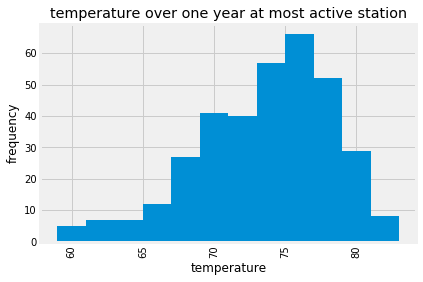

In [25]:
#plot
temps_df.hist(bins=12)
plt.title('temperature over one year at most active station')
plt.xlabel('temperature')
plt.ylabel('frequency')
plt.xticks(rotation=90)
plt.savefig('output/temp-over-one-year')
plt.show()

### Temperature Analysis

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#### my trip dates: 17/4/2018 - 28/4/2018

In [28]:
start = '2017-04-17'
end = '2017-04-28'

In [29]:
t_raw = calc_temps(start, end)
t_raw

[(67.0, 74.0, 83.0)]

In [30]:
t = list(t_raw[0])
t

[67.0, 74.0, 83.0]

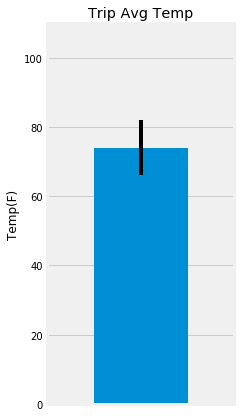

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.rcParams["figure.figsize"]=[3,7]
plt.bar(x=1, height=t[1], yerr=(t[2]-t[0])/2)
plt.title('Trip Avg Temp')
plt.ylim(0,110)
plt.xlim(0.2,1.8)
plt.ylabel('Temp(F)')
plt.xticks([])
plt.savefig('output/trip-avg-temp')
plt.show()

In [32]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.

def calc_prcp(start_date, end_date):
    return session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.avg(Measurement.prcp).label('prcp')).\
        group_by(Measurement.station).\
        order_by(desc('prcp')).\
        filter(Station.station == Measurement.station).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [33]:
print(calc_prcp(start, end))

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.6249999999999999), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.5941666666666667), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.47750000000000004), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.35222222222222216), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.23555555555555552), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.05583333333333334), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]
